In [2]:
import numpy as np
import math
import scipy.signal as ss
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Offline implementation
def ASI_detector(unfiltered_ecg,fs):
    # constants for Fs=250Hz
    Nd = 5
    Pth = 8
    Rmin = 0.25
    
    # Double derivative squared
    diff_ecg = [unfiltered_ecg[i] - unfiltered_ecg[i - Nd] for i in range(Nd, len(unfiltered_ecg))]
    ddiff_ecg = [diff_ecg[i] - diff_ecg[i - 1] for i in range(1, len(diff_ecg))]
    squar = np.square(ddiff_ecg)
        
    # Integrate moving window
    b = np.array(np.ones(Nd))
    a=[1]
    processed_ecg = signal.lfilter(b, a, squar)
    
    
    # run algo along the ecg signal
    i = 1
    tf = len(unfiltered_ecg)
    Ramptotal = 0
    
    # output peaks positions
    rpeaks = []
    
    
    # R-peak finder FSM
    while i < tf:        # run until there are no samples left
        
        # State 1: looking for maximum
        tf1 = round (i + Rmin*fs)
        Rpeakamp = 0
        while i < tf1:           
            # Rpeak amplitude and position 
            if processed_ecg[i] > Rpeakamp:
                Rpeakamp = processed_ecg[i]
                rpeakpos = i + 1
            i+=1
            
        Ramptotal = (19/20)*Ramptotal + (1/20)*Rpeakamp
        rpeaks.append(rpeakpos)
                
        # State 2: waiting state
        d = tf1 - rpeakpos
        tf2 = i + round(0.2*250 - d)   #update waiting time
        while i <= tf2:
            i+=1
            
        #State 3: decreasing threshold
        Thr = Ramptotal
        while processed_ecg[i] < Thr:
            Thr = Thr*math.exp(-Pth/fs)
            i+=1
            
    return rpeaks

In [3]:
# Real time implementation
def ASI_segmenter(unfiltered_ecg=None, sampling_rate=1000.):
        
    f1 = 3
    f2 = 45
        
    
    # FIR filter
    #b = ss.firwin(301, [f1/250, f2/250],pass_zero=False)
    #a = [1]
    #unfiltered_ecg = ss.filtfilt(b,a,unfiltered_ecg)
    
    # constants for Fs=250Hz
    Nd = 5
    Pth = 5
    Rmin = 0.25
    
    # buffers for the pre processed signals
    diff = np.zeros(len(unfiltered_ecg))
    ddiff = np.zeros(len(unfiltered_ecg))
    squar = np.zeros(len(unfiltered_ecg))
    processed_ecg = np.zeros(len(unfiltered_ecg))

    # save r-peaks position
    rpeaks = []
       
    # adaptive detection threshold
    Ramptotal = 0
    Thr = 0  # threshold 
    
    # counter for the state
    Rpeakamp = 0
    Ramptotal = 0
    counter = 6  # sets duration in each state, starting at 6 
    tf1 = round (Rmin*sampling_rate)  # time in the first state
    state = 1 # initial state of the fsm
    delay = Nd  # from the diff and ddiff

    
    # R-peak finder FSM, feeding samples from the ecg
    # counter for the main loop
    i = 1
    tf = len(unfiltered_ecg)
    
    for i in range (6,tf):
        
        # Pre-processing: derivative x[n]-x[n-Nd]; derivative x[n]-x[n-1]; squaring: x[n]^2 and integration: 5 samples
        diff[i] = unfiltered_ecg[i] - unfiltered_ecg[i - Nd]
        ddiff[i] = diff[i] - diff[i - 1]
        squar[i] = ddiff[i] * ddiff[i]
        processed_ecg[i] = (squar[i]+squar[i-1]+squar[i-2]+squar[i-3]+squar[i-4])/5
          
        
        # State 1: looking for maximum    
        # Rpeak amplitude and position 
        if state == 1: 
            if counter < tf1:
                if processed_ecg[i] > Rpeakamp:
                    Rpeakamp = processed_ecg[i]
                    rpeakpos = i                     
            else:
                state = 2
                Ramptotal = (19/20)*Ramptotal + (1/20)*Rpeakamp
                rpeaks.append(rpeakpos - delay)
                
                # setting time for state 2
                d = (i - rpeakpos)
                tf2 = tf1 +  round(0.2*250 - d)
                Thr = Ramptotal   #threshold for state 3

             
        # State 2: waiting state
        if state == 2:
            if counter > tf2:
                state = 3
                
                
        #State 3: decreasing threshold        
        if state == 3:
            if processed_ecg[i] < Thr:
                Thr = Thr*math.exp(-Pth/sampling_rate)  # exponential decay
                
            else:
                Rpeakamp = 0
                counter = 0               
                state = 1
                          
        counter += 1
        
                               
    return [rpeaks,unfiltered_ecg]

In [6]:
ti = 1000
tf = 1020


ecg_fieldwiz = np.genfromtxt("FieldWiz_Data/20200408-JM-FWv2.txt",delimiter=None) 
[rpeaks,unfiltered_ecg] = ASI_segmenter(ecg_fieldwiz,250)


time = np.arange(0, len(ecg_fieldwiz)/250, 1/250)
plt.figure(figsize=(10, 10), dpi=100);

plt.subplots_adjust(bottom=0.1, hspace=0.4)


plt.subplot(4,1,1)
plt.plot(time,ecg_fieldwiz)
plt.ylabel('Raw ECG')
#plt.xlim(0,600)
rpeaks_amp = [60/(i/250) for i in np.diff(rpeaks)]
rpeaks_time = [i/250 for i in rpeaks]

plt.subplot(4,1,2)
rpeaks_time = rpeaks_time[0:-1]
plt.plot(rpeaks_time,rpeaks_amp)
plt.ylim(40,200)
#plt.xlim(0,600)
plt.xlabel(' Time (s) ')
plt.ylabel(' Heart rate (bpm) ')


plt.subplot(4,1,3)
rr_intervals = np.diff(rpeaks)
plt.plot(rr_intervals)
plt.ylabel('RR-intervals (ms)')
plt.xlabel(' Time (s) ')

plt.subplot(4,1,4)
rpeaksamp = [ecg_fieldwiz[i] for i in rpeaks] 
plt.plot(ecg_fieldwiz)
plt.plot(unfiltered_ecg)
plt.plot(rpeaks,rpeaksamp,'*')
plt.xlim((ti*250, tf*250));
plt.ylim((-200, 100));
plt.xlabel('Sample number')
plt.legend(['Raw ECG','Filtered ECG','R-peaks'],loc='upper right')


OSError: FieldWiz_Data/20200408-JM-FWv2.txt not found.

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

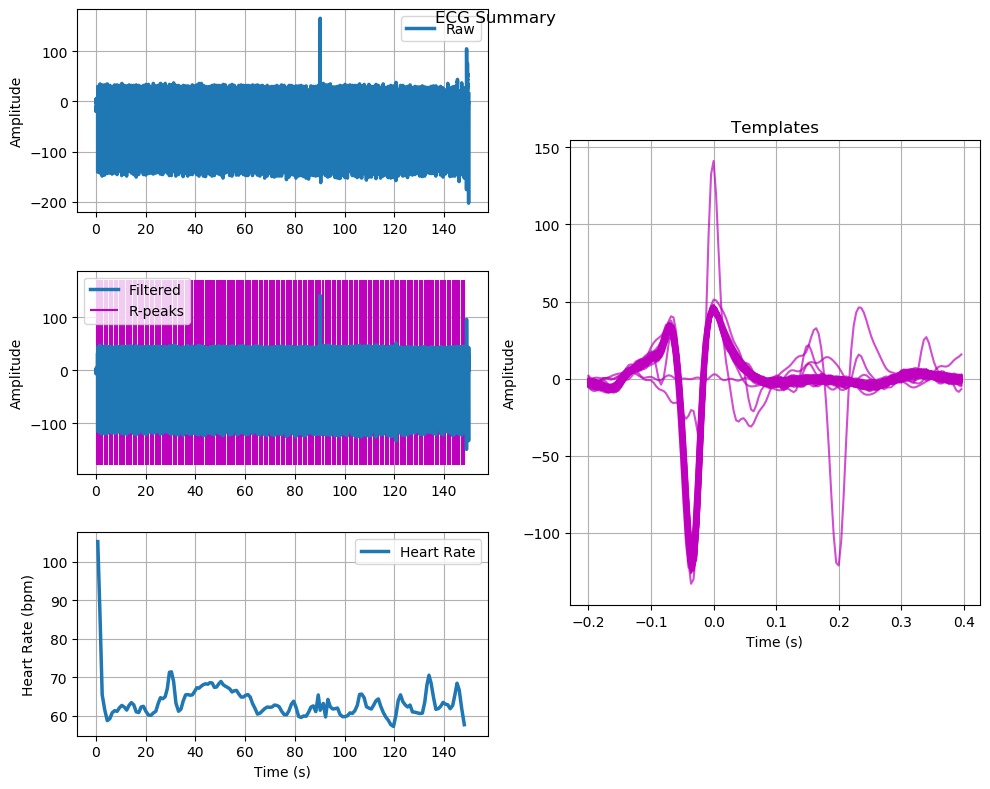

In [31]:
from biosppy.signals import ecg
input = ecg_fieldwiz[ti*250:tf*250]

plt.figure(figsize=(10, 8), dpi=100);
ecg.ecg(input,250);